In [1]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import cross_val_score
from sklearn.feature_extraction.text import HashingVectorizer, CountVectorizer
from sklearn import manifold, decomposition, linear_model, ensemble, neighbors, cross_validation
%matplotlib inline

import sklearn
import matplotlib.pyplot as plt
import xgboost
import re
import nltk



from heamy.dataset import Dataset
from heamy.estimator import Regressor, Classifier
from heamy.pipeline import ModelsPipeline


/Users/Roman/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### будем использовать в качестве метрики RMSE

In [2]:
def rmse(x,y):
    return np.mean((x - y) ** 2) ** 0.5

### загрузка данных url_domain_train. Пока работаем только с ними

In [3]:
urls_train_df = pd.read_csv('data/url_domain_train.csv', header=None, delimiter='\t')

In [4]:
urls_train_df.columns = ['id', 'url', 'count']
urls_train_df.head()

,id,url,count
0,000000014B60815F65B38258011B6C01,login.rutracker.org,1
1,000000014B60815F65B38258011B6C01,rutracker.org,4
2,000000014C03DA2A47AC433A0C755201,admin.tour-spb.net,1
3,000000014C03DA2A47AC433A0C755201,czinfo.ru,1
4,000000014C03DA2A47AC433A0C755201,forumsostav.ru,1


### нужно учесть count

#### попробуем разбивать url'ы на части: login.rutracker.org $\to$ 'login rutracker org'

In [5]:
sep_tmp = urls_train_df
sep_tmp['url'] = sep_tmp['url'].astype('str')
sep_tmp['space'] = ' '
sep_tmp['array_of_url'] = (sep_tmp['url'] + sep_tmp['space']).apply(lambda x: re.findall(r"[a-zA-Z_']+",x)) * sep_tmp['count']
sep_tmp.drop(['space'], axis = 1, inplace=True)
sep_tmp.head()

,id,url,count,array_of_url
0,000000014B60815F65B38258011B6C01,login.rutracker.org,1,"[login, rutracker, org]"
1,000000014B60815F65B38258011B6C01,rutracker.org,4,"[rutracker, org, rutracker, org, rutracker, or..."
2,000000014C03DA2A47AC433A0C755201,admin.tour-spb.net,1,"[admin, tour, spb, net]"
3,000000014C03DA2A47AC433A0C755201,czinfo.ru,1,"[czinfo, ru]"
4,000000014C03DA2A47AC433A0C755201,forumsostav.ru,1,"[forumsostav, ru]"


In [6]:
sep_URLS = pd.DataFrame(sep_tmp.groupby('id').array_of_url.apply(lambda x: x.tolist()))
sep_URLS.head()

,array_of_url
id,
000000013CB5719C0000A2C90002C101,"[[id, rambler, ru], [mail, rambler, ru], [r, ru]]"
00000001442BE24000001B7D00F50801,"[[prime, ru], [autorambler, ru], [chellak, ru]..."
00000001448580F800003F1B31FB0901,"[[bosch, korolev, ru]]"
0000000145BDB2FF000157971645E901,"[[aptekanizkihcen, ua], [colady, ru], [gorod, ..."
000000014602771F0000DB9359714C01,"[[astrorok, ru], [diets, ru], [edaplus, info],..."


In [7]:
def sep_f(x):
    a = []
    for i in range(len(x)):
        for j in range(len(x[i])):
            a.append(x[i][j])
    return " ".join(a)

In [8]:
sep_URLS['list'] = sep_URLS.array_of_url.apply(sep_f)
sep_URLS.drop(['array_of_url'], axis = 1, inplace=True)

In [9]:
sep_URLS['id'] = sep_URLS.index
sep_URLS.index = range(len(sep_URLS))
sep_URLS.columns = ['urls', 'id']

In [10]:
age_train_df = pd.read_csv('data/age_profile_train.csv', header=None, delimiter='\t')
age_train_df.columns = ['id', 'age']
age_train_df.head()

,id,age
0,000000013CB5719C0000A2C90002C101,53
1,00000001442BE24000001B7D00F50801,48
2,00000001448580F800003F1B31FB0901,28
3,0000000145BDB2FF000157971645E901,44
4,000000014602771F0000DB9359714C01,48


In [11]:
print age_train_df.shape
print age_train_df.age.nunique()

(118679, 2)
99


In [12]:
print sorted(age_train_df.age.unique())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 96, 97, 98, 99]


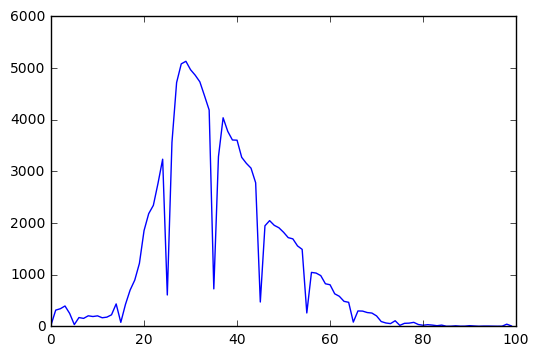

In [13]:
plt.plot(age_train_df.groupby('age')['id'].count())

In [14]:
sep_train_df = sep_URLS.merge(age_train_df, on = 'id', how='left')

In [15]:
sep_train_df.head()

,urls,id,age
0,id rambler ru mail rambler ru r ru,000000013CB5719C0000A2C90002C101,53
1,prime ru autorambler ru chellak ru docs cntd r...,00000001442BE24000001B7D00F50801,48
2,bosch korolev ru,00000001448580F800003F1B31FB0901,28
3,aptekanizkihcen ua colady ru gorod dp ua i ovk...,0000000145BDB2FF000157971645E901,44
4,astrorok ru diets ru edaplus info eshzdorovo r...,000000014602771F0000DB9359714C01,48


### стемминг слов

In [16]:
stemmer = nltk.stem.PorterStemmer()

In [17]:
def stemming(x):
    ret_array = []
    array = x.split(" ")
    for word in array:
        ret_array.append(stemmer.stem(word))
    return " ".join(ret_array)

In [18]:
stemming(sep_train_df.urls[1])

u'prime ru autorambl ru chellak ru doc cntd ru doc cntd ru echo msk ru echo msk ru expert ru expert ru expert ru expert ru expert ru expert ru expert ru financ rambler ru financ rambler ru forb ru forb ru forum ixbt com garant ru govoritmoskva ru kommers ru kp ru lenta ru mait ru metronew ru mk ru news rambler ru news rambler ru news rambler ru news rambler ru news rambler ru news rambler ru news rambler ru news rambler ru news rambler ru news rambler ru news rambler ru news rambler ru news rambler ru news rambler ru news rambler ru news rambler ru news rambler ru news rambler ru news rambler ru news rambler ru news smi ru norm load ru pfr kirov ru pfrf ru photographi on the ru realti rambler ru ren tv ren tv ren tv ren tv ren tv riafan ru rn onlin rn onlin rn onlin rn onlin rn onlin rn onlin rn onlin rn onlin rn onlin rn onlin rn onlin rn onlin rn onlin rossbanki ru secretmag ru tehnorma ru tiu ru top ru tvc ru tvzvezda ru vesti ru video rambler ru video rambler ru weekend rambler ru'

In [19]:
stem_train_df = sep_train_df.copy()

In [20]:
stem_train_df.urls = stem_train_df.urls.apply(lambda x: stemming(x))

In [21]:
sep_train_df.head()

,urls,id,age
0,id rambler ru mail rambler ru r ru,000000013CB5719C0000A2C90002C101,53
1,prime ru autorambler ru chellak ru docs cntd r...,00000001442BE24000001B7D00F50801,48
2,bosch korolev ru,00000001448580F800003F1B31FB0901,28
3,aptekanizkihcen ua colady ru gorod dp ua i ovk...,0000000145BDB2FF000157971645E901,44
4,astrorok ru diets ru edaplus info eshzdorovo r...,000000014602771F0000DB9359714C01,48


In [22]:
stem_train_df.head()

,urls,id,age
0,id rambler ru mail rambler ru r ru,000000013CB5719C0000A2C90002C101,53
1,prime ru autorambl ru chellak ru doc cntd ru d...,00000001442BE24000001B7D00F50801,48
2,bosch korolev ru,00000001448580F800003F1B31FB0901,28
3,aptekanizkihcen ua coladi ru gorod dp ua i ovk...,0000000145BDB2FF000157971645E901,44
4,astrorok ru diet ru edaplu info eshzdorovo ru ...,000000014602771F0000DB9359714C01,48


In [26]:
X_train = stem_train_df.urls
y_train = stem_train_df.age

In [29]:
tf_idf = sklearn.feature_extraction.text.TfidfVectorizer(analyzer='char', ngram_range=(1,3), stop_words='english')

In [31]:
power = [0.05, 0.1, 0.2, 0.3]

for p in power:
    score = []
    for i in range(5):
        train_data, test_data, train_labels, test_labels = cross_validation.train_test_split(X_train, y_train,\
                                                                                             test_size=0.4)
        train = tf_idf.fit_transform(train_data)
        test = tf_idf.transform(test_data)
        
        SGD = linear_model.SGDRegressor(n_iter=600, learning_rate="invscaling", power_t=p )
        SGD.fit(train, train_labels)
        ans = SGD.predict(test)
        print "rmse = ", rmse(ans, test_labels)
        score.append(ans)
    print "p = ", p, " score = ", np.array(score).mean()

 rmse =  11.7469387379
rmse =  11.7666049693
rmse =  11.6777978661
rmse =  11.7457135844
rmse =  11.7007553614
p =  0.05  score =  36.1942488053
rmse =  11.7320429102


KeyboardInterrupt: 

In [34]:
train_data, test_data, train_labels, test_labels = cross_validation.train_test_split(X_train, y_train,\
                                                                                             test_size=0.4)
train = tf_idf.fit_transform(train_data)
test = tf_idf.transform(test_data)
        
SGD = linear_model.SGDRegressor(n_iter=600, learning_rate="invscaling", power_t=0.)
SGD.fit(train, train_labels)
ans = SGD.predict(test)
print "rmse = ", rmse(ans, test_labels)

rmse =  11.7092665509


### данные для отправки

In [ ]:
urls_test_df = pd.read_csv('data/url_domain_test.csv', header=None, delimiter='\t')
urls_test_df.columns = ['id', 'url', 'count']
urls_test_df.id.nunique()

In [ ]:
urls_test_df.head()

In [ ]:
sep_tmp = urls_test_df
sep_tmp['url'] = sep_tmp['url'].astype('str')
sep_tmp['space'] = ' '
sep_tmp['array_of_url'] = (sep_tmp['url'] + sep_tmp['space']).apply(lambda x: re.findall(r"[\w']+",x)) * sep_tmp['count']
sep_tmp.drop(['space'], axis = 1, inplace=True)
sep_tmp.head()

In [ ]:
TEST_URLS = pd.DataFrame(sep_tmp.groupby('id').array_of_url.apply(lambda x: x.tolist()))

In [ ]:
TEST_URLS['list'] = TEST_URLS.array_of_url.apply(sep_f)
TEST_URLS.drop(['array_of_url'], axis = 1, inplace=True)

In [ ]:
TEST_URLS['id'] = TEST_URLS.index
TEST_URLS.index = range(len(TEST_URLS))
TEST_URLS.columns = ['urls', 'id']
TEST_URLS.head()

In [ ]:
TEST_URLS.urls = TEST_URLS.urls.apply(lambda x: stemming(x))

In [ ]:
X_test_urls = tfidf.transform(TEST_URLS.urls.values)

In [ ]:
svd_X_test = svd.transform(X_test_urls)

In [ ]:
reg.fit(svd_X, y_urls)

In [ ]:
X_test_urls.shape

In [ ]:
sep_X.shape

In [ ]:
lin_reg = linear_model.SGDRegressor(n_iter=750, alpha=0.000006)
lin_reg.fit(sep_X, y_urls)

In [ ]:
urls_pred = reg.predict(svd_X_test)

### теперь прогноз по title

In [ ]:
titles_test_df = pd.read_csv('data/title_unify_test.csv', header=None, delimiter='\t')
titles_test_df.columns = ['id', 'unify', 'count']
titles_test_df.id.nunique()

In [ ]:
tmp = titles_test_df
tmp['unify'] = tmp['unify'].astype('str')
tmp['space'] = ' '
tmp['array_of_unify'] = (tmp['unify'] + tmp['space']).apply(lambda x: x.split(' ')[:-1]) * tmp['count']
tmp.drop(['space'], axis = 1, inplace=True)
tmp.head()

In [ ]:
UNIFY_TEST = pd.DataFrame(tmp.groupby('id').array_of_unify.apply(lambda x: x.tolist()))

In [ ]:
UNIFY_TEST['list'] = UNIFY_TEST.array_of_unify.apply(f)
UNIFY_TEST.drop(['array_of_unify'], axis = 1, inplace=True)

In [ ]:
UNIFY_TEST['id'] = UNIFY_TEST.index
UNIFY_TEST.index = range(len(UNIFY_TEST))
UNIFY_TEST.columns = ['unify', 'id']
UNIFY_TEST.head()

In [ ]:
UNIFY_TEST.unify = UNIFY_TEST.unify.apply(lambda x: norm_form(x))

In [ ]:
X_test_titles = tfidf.transform(UNIFY_TEST.unify.values)

In [ ]:
lin_reg = linear_model.SGDRegressor(n_iter=750, alpha=0.000006)
lin_reg.fit(morph_X, morph_y)

In [ ]:
titles_pred = lin_reg.predict(X_test_titles)

In [ ]:
print urls_pred.shape
print titles_pred.shape

In [ ]:
TEST_URLS['age'] = urls_pred

In [ ]:
TEST_URLS = TEST_URLS[['id', 'age']]
TEST_URLS.columns = ['Id', 'age']

In [ ]:
mean_array = TEST_URLS.age.mean()

In [ ]:
mean_array

In [ ]:
TEST_URLS.head()

In [ ]:
mean_array*np.ones(10)

In [ ]:
random_sol = pd.read_csv('data/sample_submission.csv')
random_sol.head()

In [ ]:
miss_idx = set(random_sol.Id.values) - set(TEST_URLS.Id.values)
miss_df = pd.DataFrame(zip(list(miss_idx), mean_array*np.ones(len(miss_idx))))
miss_df.columns = ['Id', 'age']

In [ ]:
TEST_URLS = TEST_URLS.append(miss_df, ignore_index=True)

In [ ]:
urls_pred

In [ ]:
titles_pred

In [ ]:
mean_array = UNIFY_TEST.age.mean()

In [ ]:
UNIFY_TEST['age'] = titles_pred

In [ ]:
UNIFY_TEST = UNIFY_TEST[['id', 'age']]
UNIFY_TEST.columns = ['Id', 'age']

In [ ]:
miss_idx = set(random_sol.Id.values) - set(UNIFY_TEST.Id.values)
miss_df = pd.DataFrame(zip(list(miss_idx), mean_array*np.ones(len(miss_idx))))
miss_df.columns = ['Id', 'age']

In [ ]:
UNIFY_TEST = UNIFY_TEST.append(miss_df, ignore_index=True)

In [ ]:
print UNIFY_TEST.shape
print TEST_URLS.shape

In [ ]:
TEST = TEST_URLS.copy()

In [ ]:
TEST['age'] = TEST_URLS['age']

In [ ]:
TEST.head()

In [ ]:
TEST.to_csv('my_solution.csv', index=False)

In [ ]:
TEST.shape

In [ ]:
print urls_test_df.shape
print TEST_URLS.shape

In [ ]:
print urls_test_df.id.nunique()
print TEST_URLS.id.nunique()